<a href="https://colab.research.google.com/github/dreamer0710/StillWork_Team_5/blob/main/team_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

팀 프로젝트를 위한 노트북입니다. 이하 문제정의서 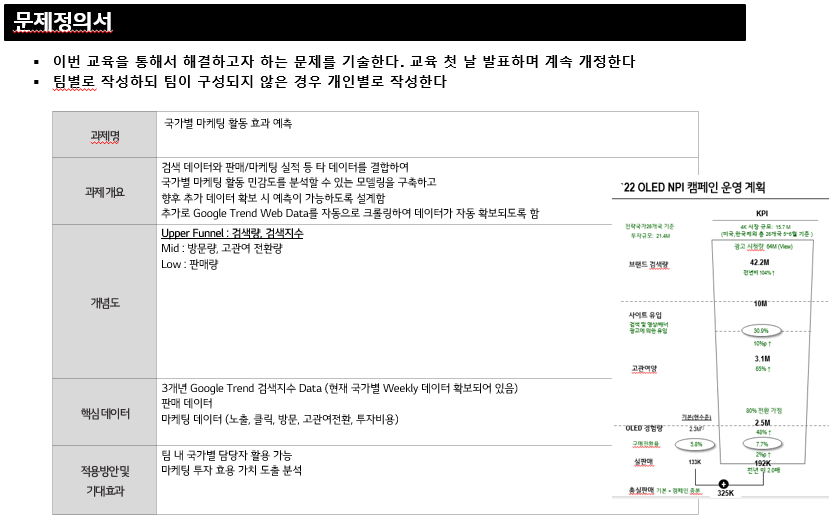

**2/16일 교육 시간에 논의된 내용**

5조 요약
- 국가단위로 보면 데이터 충분하지 않다.
- 국가별 마케팅 했을 때, 검색량, 판매 set out의 민감도 해보자
- 향후에 투자를 계속 이어갈 수 있을 거니까, 

목적 데이터 :
검색 지수, 판매
랜덤포레스트 쓰면 됨
1 hot 인코딩
입력변수는 다양하게 잘 골라야 한다.
국가는 그룹핑(클러스터링), 성격이 비슷한 국가를 묶어야함.
선진국/후진국, or 10개정도 클러스터링, 비 많이 오는 국가/ 아닌국가

# 과제 (WIP)
* 필요한 틀을 잡는 상황입니다. 수행되지 않아요 (2/17일)

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams.update({'font.size': 14})

## 테이타 파일을 읽기

In [8]:
data = pd.read_csv('https://github.com/dreamer0710/StillWork_Team_5/raw/main/Team_5_data.csv')
print(data.shape)
data.head()

(9736, 37)


,YEAR,MONTH,Q,Region,법인,COUNTRY,성숙도,기간1,기간2,미디어,미디어2,Spending(M$)\n_Seeding,Spending(M$)\n_SEM,Spending(M$)_Digital,WTB_Seeding,WTB_SEM,WTB,OLED 검색량 TTL,LG OLED 검색량 TTL,LG OLED 검색량 Low,Seeding WTB Upper+Mid,Seeding WTB Low,SEM WTB Brand+Core,SEM WTB Low,Comp_campaign,TVC_GRP,Spending(M$)_TVC,GRP_High BM,Comp_GRP,Sell-out,selout_remarks,Week,QLED,LG OLED,SONY OLED,OLED,4K
0,2019,1,1,Oceania,Australia,Australia,성숙,캠페인이전,캠페인이전,No media,No,-,-,-,-,-,-,-,-,-,-,-,-,-,NaN,NaN,NaN,NaN,NaN,1802,NaN,2019-01-06,8.0,7.0,1.0,19.0,76
1,2019,1,1,Oceania,Australia,Australia,성숙,캠페인이전,캠페인이전,No media,No,-,-,-,-,-,-,-,-,-,-,-,-,-,NaN,NaN,NaN,NaN,NaN,1147,NaN,2019-01-13,4.0,4.0,2.0,12.0,52
2,2019,1,1,Oceania,Australia,Australia,성숙,캠페인이전,캠페인이전,No media,No,-,-,-,-,-,-,-,-,-,-,-,-,-,NaN,NaN,NaN,NaN,NaN,1383,NaN,2019-01-20,4.0,6.0,1.0,15.0,58
3,2019,1,1,Oceania,Australia,Australia,성숙,캠페인이전,캠페인이전,No media,No,-,-,-,-,-,-,-,-,-,-,-,-,-,NaN,NaN,NaN,NaN,NaN,1506,NaN,2019-01-27,5.0,4.0,0.5,10.0,56
4,2019,2,1,Oceania,Australia,Australia,성숙,캠페인이전,캠페인이전,No media,No,-,-,-,-,-,-,-,-,-,-,-,-,-,NaN,NaN,NaN,NaN,NaN,1021,NaN,2019-02-03,4.0,4.0,0.5,8.0,56


### 데이타 조정하기

*   국가(country) 그룹핑이 필요

참고: [d_23_Clusters.ipynb](https://colab.research.google.com/github/StillWork/HE_0216/blob/main/d_23_Clusters.ipynb#scrollTo=301baf6b)

In [10]:
df = data.copy() # 원본 복사에서 사용함
print(df.shape)


(9736, 37)


## Random Forest Regressor 로 학습시키기

In [3]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
show_reg_result(y_test,y_pred)

NameError: ignored

In [ ]:
cross_validation(rfr,X,y)

In [ ]:
plot_feature_weight(X.columns, rfr.feature_importances_)